# **Finetuned ResNet50**

## **Imports**

In [1]:
import json
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.backend import clear_session
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from utils import load_images
from utils import TrainingPlot

clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **Parameters**

In [2]:
MODEL_VERSION = "_resNet50_3.1"
METADATA = pd.read_csv('../src/meta_data.csv')
IMAGE_FOLDER = "../src/final_data"

PARAMETERS = {
    "MODEL_VERSION": MODEL_VERSION,
    "IMG_HEIGHT": 128,
    "IMG_WIDTH": 128,
    "NUM_CLASSES": 19,
    "TEST_SPLIT": 0.3,
    "BATCH_SIZE": 128,
    "EPOCHS": 50,
    "LEARNING_RATE": [0.0001, 0.00001, 0.000001, 0.0000001],
    }

with open(f"../src/models/resNet50/{MODEL_VERSION}/parameters{MODEL_VERSION}.json", "w") as json_file:
    json.dump(PARAMETERS, json_file, indent=4)

## **Load Images & Labels**

In [3]:
with tf.device("CPU:0"):
    METADATA = pd.read_csv('../src/meta_data.csv')

    # Load images and labels
    image_folder = '../src/final_data'
    images, labels = load_images(image_folder, METADATA, PARAMETERS["IMG_HEIGHT"], PARAMETERS["IMG_WIDTH"])

    # Normalize images
    images = images / 255.0

    # Encode labels
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded)

    # Train / Test Split
    X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

    del images
    del labels
    del labels_categorical

Processing: 100%|██████████| 57141/57141 [01:19<00:00, 717.37it/s]


In [4]:
# create a mapping of all labels
label_mapping = {}

for i in range(len(label_encoder.classes_)):
    label_mapping[i] = label_encoder.inverse_transform([i])[0]

file_path = f'../src/models/resNet50/{MODEL_VERSION}/label_mapping_{MODEL_VERSION}.json'
with open(file_path, 'w') as file:
    json.dump(label_mapping, file, indent=4)
print(label_mapping)

{0: '1 Series', 1: '2 Series', 2: '2 Series Active Tourer', 3: '4 Series Gran Coupe', 4: '5 Series', 5: '911', 6: 'A Class', 7: 'C Class', 8: 'E Class', 9: 'Golf', 10: 'M4', 11: 'Macan', 12: 'Passat', 13: 'Scirocco', 14: 'Touareg', 15: 'X3', 16: 'X5', 17: 'X6', 18: 'up!'}


## **Create Model**

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(PARAMETERS["IMG_HEIGHT"], PARAMETERS["IMG_WIDTH"], 3))

x = base_model.output
x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=HeNormal())(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


## **Training**

In [6]:
with tf.device("CPU:0"):
    # Train the model
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../src/models/resNet50/{MODEL_VERSION}/best_model{MODEL_VERSION}.keras', monitor='loss', save_best_only=True, mode='min')
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, mode='min')

    def lr_schedule(epoch, lr):
        if epoch < 5:
            return 0.0001
        elif epoch < 10:
            return 0.00001
        elif epoch < 15:
            return 0.000001
        else:
            return 0.0000001

    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_split=PARAMETERS["TEST_SPLIT"],
        epochs=PARAMETERS["EPOCHS"],
        batch_size=PARAMETERS["BATCH_SIZE"],
        callbacks=[early_stopping, TrainingPlot(MODEL_VERSION, f"../src/models/resNet50/{MODEL_VERSION}/"), checkpoint, lr_scheduler]
)

Epoch 1/50
250/250 [==============================] - 1893s 8s/step - loss: 2.4449 - accuracy: 0.2577 - val_loss: 2.9478 - val_accuracy: 0.0491 - lr: 1.0000e-04
Epoch 2/50
250/250 [==============================] - 1764s 7s/step - loss: 1.3335 - accuracy: 0.5904 - val_loss: 2.9379 - val_accuracy: 0.0604 - lr: 1.0000e-04
Epoch 3/50
250/250 [==============================] - 4585s 18s/step - loss: 0.6820 - accuracy: 0.7910 - val_loss: 2.2187 - val_accuracy: 0.4132 - lr: 1.0000e-04
Epoch 4/50
250/250 [==============================] - 1935s 8s/step - loss: 0.4292 - accuracy: 0.8671 - val_loss: 1.5356 - val_accuracy: 0.6482 - lr: 1.0000e-04
Epoch 5/50
250/250 [==============================] - 1878s 7s/step - loss: 0.3002 - accuracy: 0.9130 - val_loss: 0.7095 - val_accuracy: 0.8122 - lr: 1.0000e-04
Epoch 6/50
250/250 [==============================] - 1840s 7s/step - loss: 0.1774 - accuracy: 0.9486 - val_loss: 0.2785 - val_accuracy: 0.9191 - lr: 1.0000e-05
Epoch 7/50
250/250 [=============

KeyboardInterrupt: 

In [7]:
model.save(f"../src/models/resNet50/{MODEL_VERSION}/model_v{MODEL_VERSION}.keras")
model.save(f"../src/models/resNet50/{MODEL_VERSION}/model_v{MODEL_VERSION}.h5")

In [9]:
with tf.device("CPU:0"):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)

358/358 [==============================] - 202s 566ms/step - loss: 0.3716 - accuracy: 0.9257


In [14]:
with tf.device("CPU:0"):
    y_pred = model.predict(X_test)
    y_pred_class = np.argmax(y_pred, axis=1
    y_pred_class

358/358 [==============================] - 136s 381ms/step


In [32]:
# convert predicted labels to string representation
y_pred_labels = [label_mapping[label] for label in y_pred_class]

# decode encoded labes to numeric values and convert the to the string representations again
y_test_numeric = np.argmax(y_test, axis=1)
y_test_labels = [label_mapping[label] for label in y_test_numeric]

Classification Report:
                        precision    recall  f1-score   support

              1 Series       0.93      0.96      0.94       737
              2 Series       0.94      0.93      0.94       657
2 Series Active Tourer       0.94      0.95      0.94       402
   4 Series Gran Coupe       0.78      0.90      0.84       409
              5 Series       0.91      0.88      0.89       518
                   911       0.98      0.97      0.97       722
               A Class       0.95      0.93      0.94       446
               C Class       0.73      0.85      0.79       420
               E Class       0.87      0.72      0.79       488
                  Golf       0.96      0.95      0.96      1041
                    M4       0.95      0.86      0.90       416
                 Macan       0.96      0.96      0.96       535
                Passat       0.96      0.96      0.96      1072
              Scirocco       0.93      0.94      0.94       418
               T

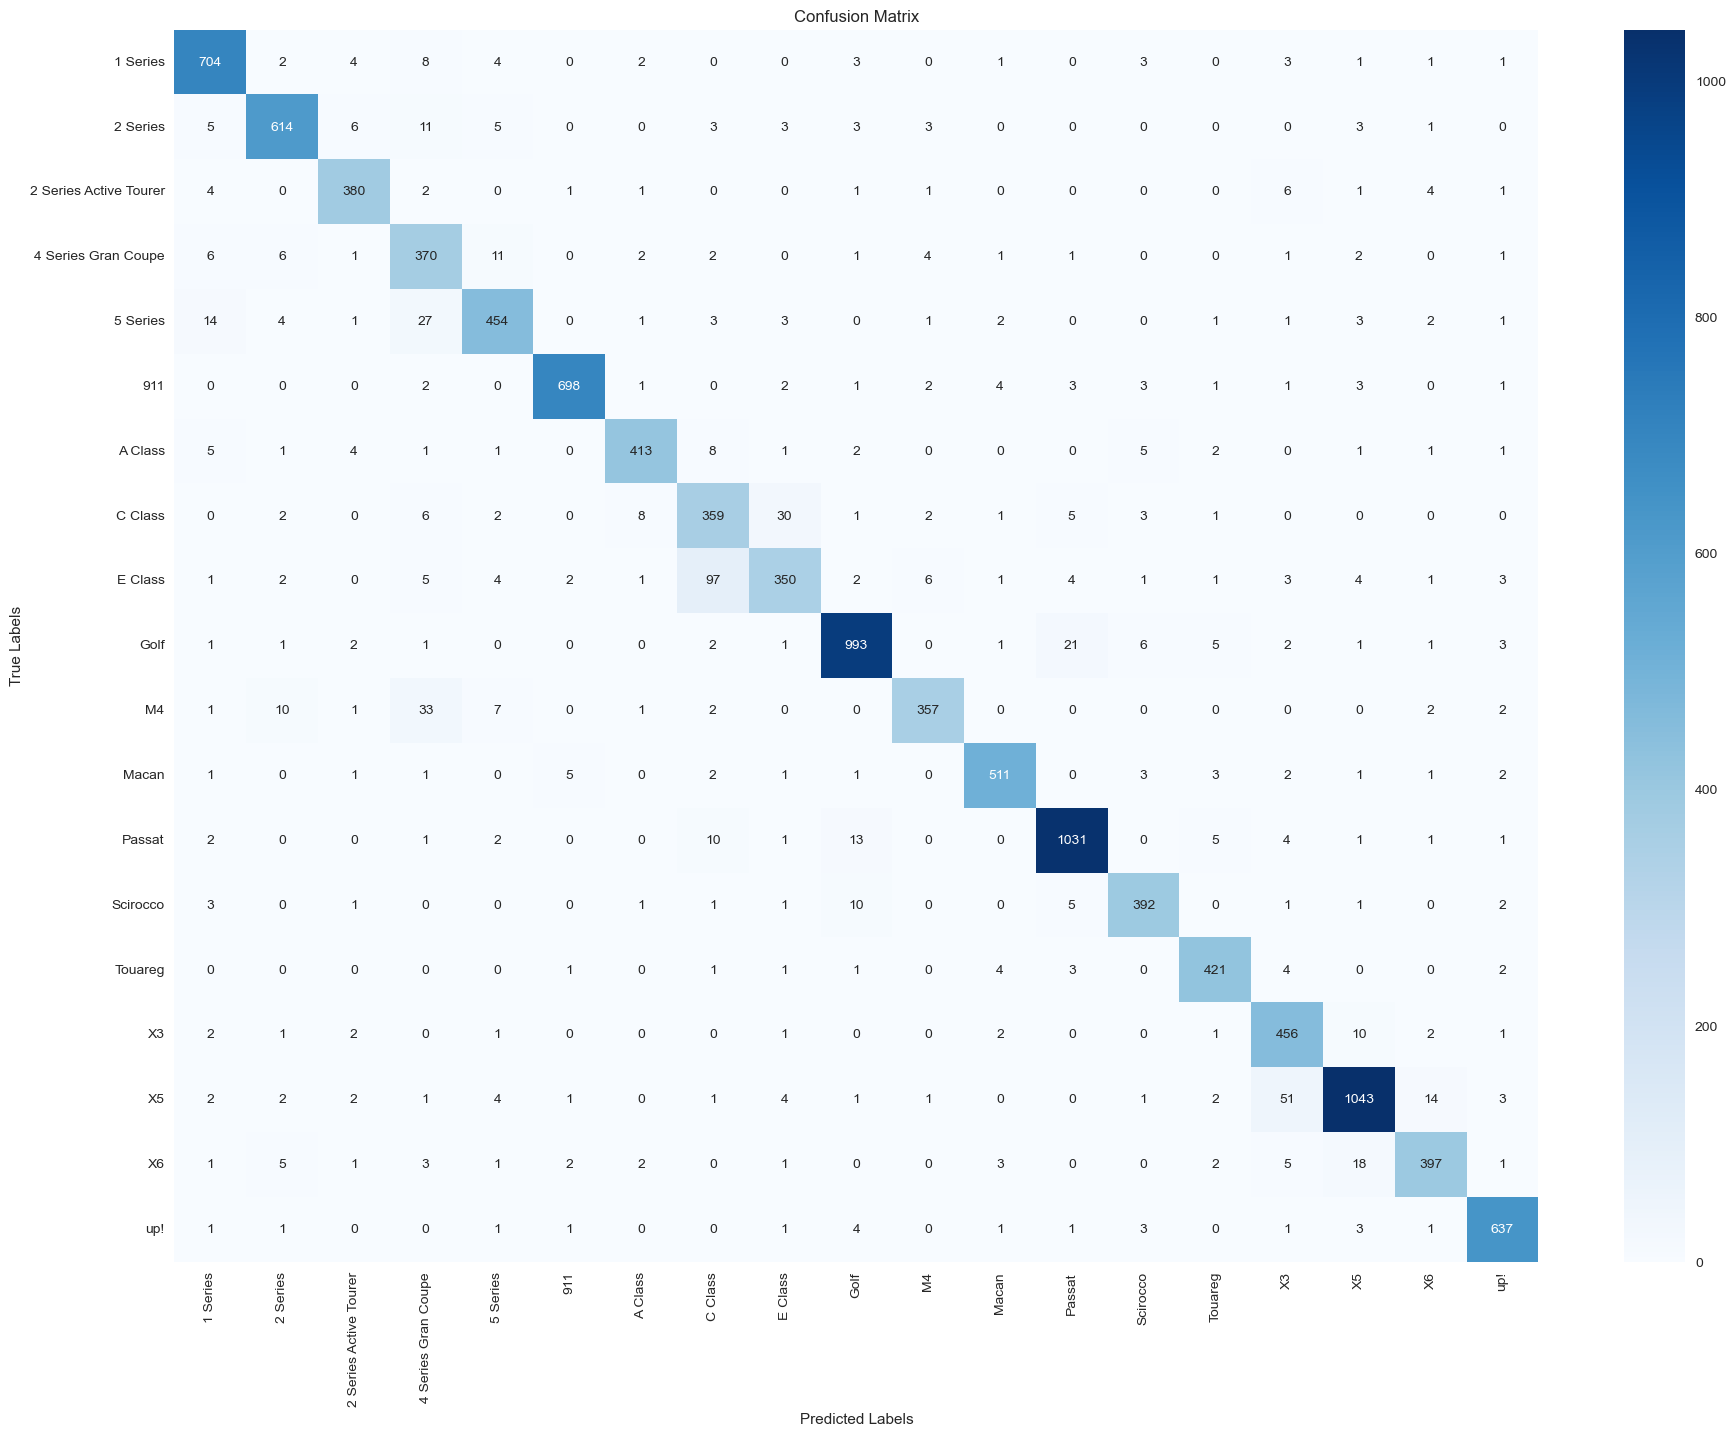

In [45]:
print('Classification Report:')
classification_report_str = classification_report(y_test_labels, y_pred_labels)
print(classification_report_str)

with open(f'../src/models/resNet50/{MODEL_VERSION}/classification_report_{MODEL_VERSION}.txt', 'w') as f:
    f.write('Classification Report:\n')
    f.write(classification_report_str)
    f.write(f'\nAccuracy: {test_accuracy}\n')

print('Confusion Matrix:')
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(22, 16))
sns.heatmap(conf_matrix, annot=True, fmt='', cmap='Blues', 
            xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig(f"../src/models/resNet50/{MODEL_VERSION}/conf_matrix_{MODEL_VERSION}.png", dpi=300)
plt.show()

In [ ]:
del X_train
del X_test
del y_train
del y_test
del images
del labels
del label_encoder
del labels_encoded
del model